# Real-world representation using tensors
- Jackson Cown
- 6/10/22


#### In This Chapter:
- Represent real-world data as PyTorch Tensors
- Working with a range of data file type
- Loading data from a file
- Converting data to tensors
- Shaping tensors so they can be used as inputs to neural network models

In [5]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Real-world data as tensors
- Tensors are the building blocks of data in PyTorch
- NNs take tensors as input and produce tensors as outputs
- In fact, all operations within a neural network during optimization are operations between tensors
- How do we take a piece of data, a video, or a line of text, and represent it with a tensor in a way that is appropriate for training a deep learning model?
    - Each section in this chapter will describe a data type, and will come with their own datasets

### Working with images
- Since the reemergence of deep learning in 2012, Convolutions Neural Networks (CNNs) have been at the forefront of the research community.
    - The primary use of these CNNs is in processing 2D image data but it is not limited to only this
- An image is represented as a collection of scalars arranged in a regular grid with a height and a width (in pixels)
- We might have a single scalar grid point (grayscale img), or multiple scalars per grid point (color img)
    - Or we can have an axis representing depth or other types of features
- Scalar represented values are often encoded with 8-bit integers, as in consumer cameras.
    - Medical, scientific, and industrial applications use higher numerical precision, such as 12-bit or 16-bit
    - This allows for a wider range of sentivity in cases where the pixel encodes information about a physical property (like temperature)


#### Adding color channels
- There are several ways to encode color into numbers, the most common being RGB. (3 channels representing Red, Blue, and Green respectively.
    - We can think of a color channel as a grayscale intensity map of only the color in question


#### Loading an image file
- Loading PNG images using ```imageio``` module

In [6]:
# Loading png images
import imageio.v2 as imageio
from matplotlib import pyplot as plt

In [7]:
img_arr = imageio.imread('./data/p1ch4/image-dog/bobby.jpg')

(720, 1280, 3)
uint8


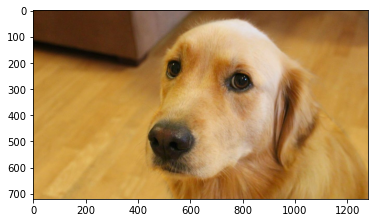

In [8]:
print(img_arr.shape)
print(img_arr.dtype)
plt.imshow(img_arr)

At this point, ```img_arr``` is a NumPy array-like object with 3 dimensions:
- Two Spatial Dimensions
    - Width and Height
- One dimension corresponding to color intensity (RGB)
- Default notation for image dimensions in PyTorch is **CxHxW**: Channels, Height, Width


#### Changing the layout
- We can use the tensors ```permute``` method with the old dimensions for eacvh new dimension to get an appropriate layout.
- Given a tensor **HxWxC**, we get a proper layout by swapping each index by up one

In [9]:
img = torch.from_numpy(img_arr)
print(f'Original image shape: {img.shape}')
out = img.permute(2, 0, 1) # Does not make a copy, only changes tensor view of storage
print(f'Permuted image shape: {out.shape}')
print(out.dtype)

Original image shape: torch.Size([720, 1280, 3])
Permuted image shape: torch.Size([3, 720, 1280])
torch.uint8


To create a dataset of multiple images to use during training, we store the images in a batch along the first dimension to obtain a **NxCxHxW** tensor

In [10]:
#img batching
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)
# Each batch consists of 3 RGB images 256x256

We can also load all PNG images from an input directory and store them in the tensor:

In [11]:
import os

data_dir = './data/p1ch4/image-cats'
filenames = [name for name in os.listdir(data_dir)
            if os.path.splitext(name)[-1] == '.png']
print(filenames)

['cat1.png', 'cat2.png', 'cat3.png']


In [12]:
for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3] # Here we only keep the first 3 channels (sometimes there is an alpha channel)
    batch[i] = img_t

#### Normalizing the data
- Images are natively integer values ranging from 0-255
    - We need to adjust this because neural networks learn better when the output is bounded between 0 to 1 or from -1 to 1
- A common thing to do is to cast a tensor to floating-point dtype and normalize the pixel values
- An easy way to do this is to just convert to float and divide by 255 element wise on each image

In [13]:
batch = batch.float()
batch /= 255.0
print(batch[0, 0])

tensor([[0.6118, 0.5961, 0.4863,  ..., 0.5882, 0.5843, 0.6196],
        [0.6824, 0.5255, 0.6471,  ..., 0.4706, 0.5333, 0.5412],
        [0.4980, 0.6118, 0.4196,  ..., 0.5137, 0.5608, 0.6431],
        ...,
        [0.4549, 0.5098, 0.5059,  ..., 0.4980, 0.4627, 0.4392],
        [0.5059, 0.5098, 0.4824,  ..., 0.4510, 0.4745, 0.4471],
        [0.5059, 0.4824, 0.4627,  ..., 0.4431, 0.4745, 0.4706]])


- Another way to do it is to compute the mean and standard deviation of the input data and scale it so the output has zero mean and unit standard deviation across each channel:

In [14]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std
print(batch[0, 0])

tensor([[ 0.1439,  0.0730, -0.4234,  ...,  0.0375,  0.0198,  0.1794],
        [ 0.4631, -0.2461,  0.3035,  ..., -0.4944, -0.2107, -0.1752],
        [-0.3703,  0.1439, -0.7249,  ..., -0.2993, -0.0866,  0.2858],
        ...,
        [-0.5653, -0.3171, -0.3348,  ..., -0.3703, -0.5298, -0.6362],
        [-0.3348, -0.3171, -0.4412,  ..., -0.5830, -0.4766, -0.6007],
        [-0.3348, -0.4412, -0.5298,  ..., -0.6185, -0.4766, -0.4944]])


Note:
- Here we normalize only a single batch of images because we do not know yet how to operate on an entire dataset.
    - With image data, it can be better to compute the mean and standard deviation over the whole dataset
- We can perform several other operations on the inputs, such as geometric transforms like rotations, scaling, and cropping
    - These may help with training or may be required to make an arbitrary input conform to the input requirements of a network, like image size.

### 3D Images: Volumetric Data
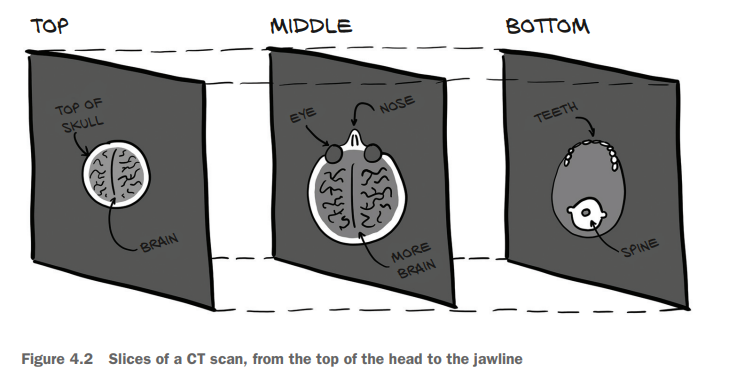
- In some contexts, such as medical imaging with CT (Computed tomography) scans, we deal with sequences of images stacked along the head-to-foot axis, each corresponding to a slice across the human body.
    - In CT Scans, the intensity represents the density of the different parts of the body
    - CTs only have a single intensity channel, similar to grayscale images
        - This means that often, the channel dimension is left out of native data formats
        - Similar to the last example, the raw data only has 3 dimensions
        - By stacking 2D slices into a 3D tensor, we can build a volumetric representation of 3D anatomy
        - Unlike the image data, the extra dimension represents the offset of physical space, rather than a particular band of the visible spectrum
- Part 2 of this book will tackle a medical imaging problem
- For now, an abstract idea of volumetric data can be represented in a 5D tensor **NxCxDxHxW** (Batch_size, channel, density, height, width)

#### Loading a specialized format
- Loading a sample CT scan using ```volread``` in ```imageio```

In [15]:
dir_path = './data/p1ch4/volumetric-dicom/2-LUNG 3.0  B70f-04083'
vol_arr = imageio.volread(dir_path, 'DICOM')
print(vol_arr.shape)

Reading DICOM (examining files): 1/99 files (1.0%26/99 files (26.3%52/99 files (52.5%79/99 files (79.8%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 76/99  (76.899/99  (100.0%)
(99, 512, 512)


PyTorch expects a channels dimension, which we can make using ```unsqueeze```

In [16]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)
print(vol.shape) # [Channel, Density, 

torch.Size([1, 99, 512, 512])


At this point we could build a 5D dataset by stacking multiple volumes along the batch direction

### Representing Tabular Data
- The simplest data in machine learning is sitting in a spreadsheet, CSV, or database as a table
    - One row per sample
    - One row per feature
- At first we will assume there is no meaning to the order of samples by row in the dataset
    - The data is a collection of independent samples
    - We will look at time series data soon
- Tabular data is typically not homogenous (One data type)
    - PyTorch tensors are homogenous so we need to be weary


#### Using a real-world dataset
- Encode heterogeneous, real-world data into a tensor of floating-point numbers
- We will be working with the Wine Quality dataset containing chemical characterizations of portugese wines
- A possible ML task with this data is predicting the quality score of a wine from its chemical characterization


#### Loading a wine data tensor
- 3 Options for loading a CSV file:
    - The ```csv``` module shipped with python
    - NumPy
    - Pandas
        - Pandas is the most time and memory efficient, but it won;t be touched on here

In [56]:
import csv
# Load data
wine_path = './data/p1ch4/tabular-wine/winequality-white.csv'
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=';', skiprows=1) # Cast to 32-bit
print(wineq_numpy)

[[ 7.    0.27  0.36 ...  0.45  8.8   6.  ]
 [ 6.3   0.3   0.34 ...  0.49  9.5   6.  ]
 [ 8.1   0.28  0.4  ...  0.44 10.1   6.  ]
 ...
 [ 6.5   0.24  0.19 ...  0.46  9.4   6.  ]
 [ 5.5   0.29  0.3  ...  0.38 12.8   7.  ]
 [ 6.    0.21  0.38 ...  0.32 11.8   6.  ]]


In [55]:
# Checking data
col_list = next(csv.reader(open(wine_path), delimiter=';'))
print(wineq_numpy.shape, col_list)

(4898, 12) ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [58]:
wineq = torch.from_numpy(wineq_numpy) # convert to torch tensor
print(wineq.shape, wineq.dtype)

torch.Size([4898, 12]) torch.float32
